# image classification with PyTorch

## import libraries

In [1]:
# . . import libraries
import os
from pathlib import Path
# . . pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# . . numpy
import numpy as np
# . . scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# . . matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as npimg
# . .  set this to be able to see the figure axis labels in a dark theme
from matplotlib import style
#style.use('dark_background')
# . . to see the available options
# print(plt.style.available)

from torchsummary import summary

# . . import libraries by tugrulkonuk
import utils
#from dataset import Dataset
from model import *
from trainer import Trainer
from callbacks import ReturnBestModel, EarlyStopping


# set device and precision

In [2]:
# . . set the device
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = torch.device("cpu")      
# . . set the default tensor to cuda: DO NOT USE THIS
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True

torch.backends.cudnn.enabled = True

In [3]:
# . . arguments . .
# . . this is only for the Jupyter notebook as there is no command line
class Args():
    # . . number of epochs 
    epochs = 80
    # . . the learning rate 
    lr = 0.001

    # . . batch_size
    batch_size = 256

    # . . fraction of data to be used in training
    train_size = 0.8

    # . . min delta (min improvement) for early stopping
    min_delta = 0.0005

    # . . patience for early stopping
    patience = 10

    # . . number of workers for the data loader
    num_workers = 8

    # . . use pinn memory for faster CPU-GPU transler
    pin_memory = False

    # . . print interval
    jprint = 1



In [4]:
# . . instantiate the command-line parameters object
args = Args()

# . . get command-line parameters
num_epochs    = args.epochs
batch_size    = args.batch_size
learning_rate = args.lr
train_size    = args.train_size
min_delta     = args.min_delta
patience      = args.patience 
num_workers   = args.num_workers
pin_memory    = args.pin_memory
jprint        = args.jprint

## import the data


In [5]:
# . . transformer for data augmentation
transformer_train = torchvision.transforms.Compose([
  # torchvision.transforms.ColorJitter(
  #     brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  transforms.RandomCrop(32, padding=4),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  # torchvision.transforms.RandomRotation(degrees=15),
  torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # torchvision.transforms.RandomPerspective(),
  transforms.ToTensor(),                                            
])

# . . the train set
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True)

# . . the validation set: no augmentation!
valid_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
# . . the number of classes in the data
num_classes = len(set(train_dataset.targets))
print('number of classes: ',num_classes)

number of classes:  10


## data loaders

In [7]:
# . . the training loader: shuffle
trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the test loader: no shuffle
validloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

In [8]:
# . . instantiate the model
model = CNNClassifier(num_classes)

# . . send model to device (GPU)
model.to(device)

CNNClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 1

In [9]:
# . . show a summary of the model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6

(tensor(2396330), tensor(2396330))

In [10]:
# . . create the trainer
trainer = Trainer(model, device)

# . . compile the trainer
# . . define the loss
criterion = nn.CrossEntropyLoss()

# . . define the optimizer
optimparams = {'lr':learning_rate
              }

# . . define the callbacks
cb=[ReturnBestModel(), EarlyStopping(min_delta=min_delta, patience=patience)]

trainer.compile(optimizer='adam', criterion=criterion, callbacks=cb, jprint=jprint, **optimparams)

# . . the learning-rate scheduler
schedulerparams = {'factor':0.5,
                   'patience':50,
                   'threshold':1e-5,
                   'cooldown':5,
                   'min_lr':1e-5,                
                   'verbose':True               
                  }
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, **schedulerparams)

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0


In [11]:
# . . train the network
train_loss, valid_loss = trainer.fit(trainloader, validloader, scheduler=None, num_epochs=num_epochs)

Training started:  January 19, 2021 - 11:54PM
Epoch:     0	Train Loss: 1.421259	Valid Loss: 1.160705	Elapsed time: 0:00:04.827248
Epoch:     1	Train Loss: 0.985535	Valid Loss: 0.850697	Elapsed time: 0:00:04.531829
Epoch:     2	Train Loss: 0.808874	Valid Loss: 0.772938	Elapsed time: 0:00:04.494268
Epoch:     3	Train Loss: 0.695151	Valid Loss: 0.680726	Elapsed time: 0:00:04.520826
Epoch:     4	Train Loss: 0.626770	Valid Loss: 0.602169	Elapsed time: 0:00:04.537591
Epoch:     5	Train Loss: 0.564515	Valid Loss: 0.536874	Elapsed time: 0:00:04.527349
Epoch:     6	Train Loss: 0.529884	Valid Loss: 0.529332	Elapsed time: 0:00:04.577200
Epoch:     7	Train Loss: 0.489546	Valid Loss: 0.491788	Elapsed time: 0:00:04.552404
Epoch:     8	Train Loss: 0.456955	Valid Loss: 0.500805	Elapsed time: 0:00:04.551934
Epoch:     9	Train Loss: 0.435371	Valid Loss: 0.469437	Elapsed time: 0:00:04.559299
Epoch:    10	Train Loss: 0.415679	Valid Loss: 0.475374	Elapsed time: 0:00:04.534727
Epoch:    11	Train Loss: 0.399

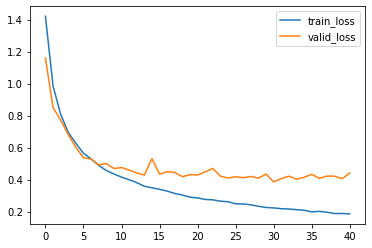

In [12]:
# . . plot the training and validation losses
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'])

In [13]:
# . . training dataset without augmentation
train_dataset_noaug = torchvision.datasets.CIFAR10(
                      root='.',
                      train=True,
                      transform=transforms.ToTensor(),
                      download=True)

# . . data loader for the training dataset without transforms
trainloader_noaug = torch.utils.data.DataLoader(
                     dataset=train_dataset_noaug, 
                     batch_size=batch_size, 
                     shuffle=False,
                     num_workers=num_workers,
                     pin_memory=pin_memory)

Files already downloaded and verified


In [14]:
# . . evaluate the accuracy of the trained network
training_accuracy, test_accuracy = trainer.evaluate(trainloader_noaug, validloader)

Training accuracy: 0.9557, Test accuracy: 0.8847


The confusion matrix is not normalized
[[907   5  25   9   5   2   5   8  22  12]
 [  6 943   1   2   0   1   1   3   7  36]
 [ 34   1 814  40  35  30  30  10   3   3]
 [  8   1  28 787  29  93  30  19   3   2]
 [  9   1  26  43 850  20  22  25   3   1]
 [  3   2  16  89  18 842   7  21   0   2]
 [  6   3  19  23   8  10 923   4   2   2]
 [  4   0  10  25  18  21   3 915   0   4]
 [ 30  10   5   8   1   2   1   4 927  12]
 [  5  28   1   3   1   1   4   5  13 939]]


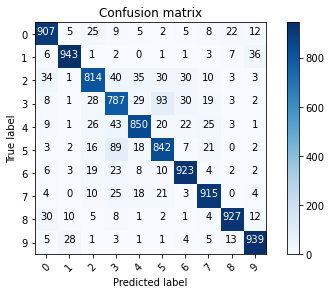

In [15]:
#. . calculate and plot the confusion matrix
x_test = valid_dataset.data
y_test = np.array(valid_dataset.targets)
p_test = np.array([])

for inputs, targets in validloader:
    # . . move to device
    inputs, targets = inputs.to(device), targets.to(device)

    # . . forward pass
    outputs = trainer.model(inputs)

    # . . predictions
    _, predictions = torch.max(outputs, 1)

    # . . update the p-test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

# . . the confusion matrix
cm = confusion_matrix(y_test, p_test)

# . . plot the confusion matrix 
utils.plot_confusion_matrix(cm, list(range(10)))